In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from GTSRBNet import GTSRBNet
from GTSRBDataset import GTSRBDataset
from matplotlib import pyplot as plt

In [2]:
root = ''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))])

validset = GTSRBDataset('valid_us.npz', transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=256,
                                          shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = GTSRBNet()
model.to(device)

classes = []
with open(root + 'class_semantics.txt') as f:
    for line in f:
        classes.append(line.strip())

checkpoint = torch.load('checkpoint_us.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

GTSRBNet(
  (conv1_1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv2_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2_1): Dropout2d(p=0.5, inplace=False)
  (conv3_1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3_1): Dropout2d(p=0.5, inplace=False)
  (conv4_1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool4_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4_1): Dropout2d(p=0.5, inplace=False)
  (fc5_1): Linear(in_features=2048, out_features=1024,

Priority road
tensor(12)


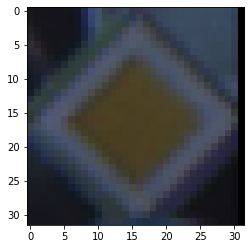

In [39]:
ite = next(iter(validloader)) #batch of 256
classidx = ite[1][0]
o_class = classes[classidx]
print(o_class)
print(classidx)
classes[16]
input_ime = ite[0][0].cuda()
input_im = input_ime.unsqueeze(0)
imshow(input_ime.cpu())

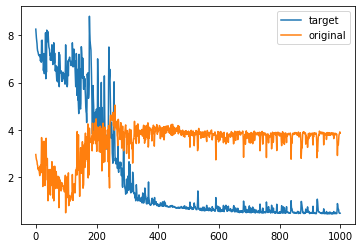

In [40]:
#TODO: Bound the ft/gy so that the image is a valid rgb image.
#TODO: See if Conv1d is an accurate representation of the convolution

# The input time signal
ft = torch.ones([1,1,36,1], requires_grad=True, dtype=torch.float, device=device)

#The shutter function is encoded into the convolution layer
lay = torch.nn.Conv1d(1,1,5)
lay.to(device)

#Manually setting the weights and bias so the  shutter acts as a box filter
lay.weight.data = torch.ones([1,1,5,1], requires_grad=True, dtype=torch.float, device=device)
lay.bias.data = torch.zeros(1, requires_grad=True, dtype=torch.float, device=device)

#Target and original class labels
target = torch.tensor([16], dtype=torch.long, device=device)
orig = torch.tensor([classidx], dtype=torch.long, device=device)
targloss = []
origloss = []

lr = 1e-1
n_epochs = 1000
optimizer = optim.SGD([ft], lr=lr)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    
    # Compute g(y) to get X_adv
    gy = lay(ft)    #Convolution of ft and the shutter
    inp = input_im * gy           #gy is broadcasted to match the shape of input_im
    out = model(inp)
    
    #Calculate Loss
    loss = loss_fn(out, target)
    targloss.append(loss.data)
    origloss.append(loss_fn(out,orig))
    loss.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    
plt.plot(targloss, label="target")
plt.plot(origloss, label="original")
plt.legend()
plt.show()

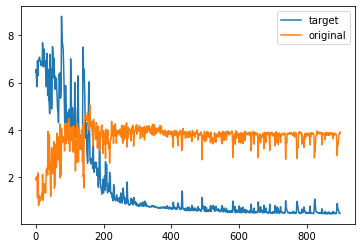

In [41]:
plt.plot(targloss[100:], label="target")
plt.plot(origloss[100:], label="original")
plt.legend()
plt.show()

In [8]:
def imshow(img):
    img = img + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


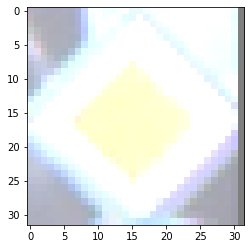

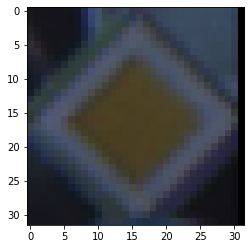

In [42]:
inp2 = (input_ime - torch.min(input_ime))
inp2 /= torch.max(inp2)
imshow(inp2.cpu())
imshow(input_ime.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


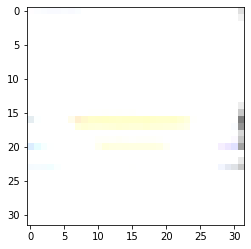

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


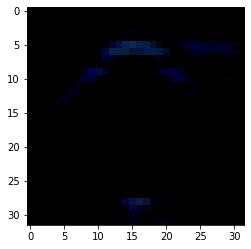

In [43]:
inp2 = (inp - torch.min(inp))
inp2 /= torch.max(inp2)
imshow(inp2[0].detach().cpu())
imshow(inp[0].detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


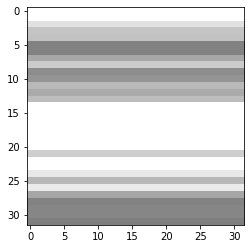

In [44]:
test = torch.ones([1,3,32,32], device=device)
test2 = gy - torch.min(gy)
test2 /= torch.max(test2)
test = test * test2
imshow(test[0].detach().cpu())

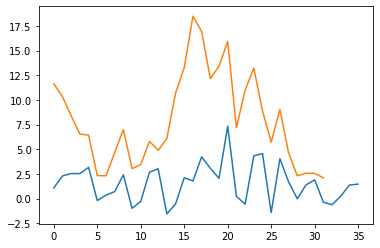

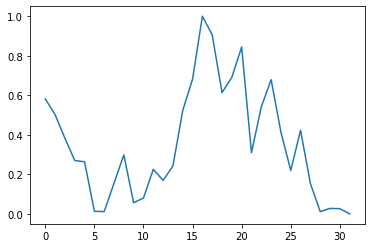

In [45]:
plt.plot(torch.flatten(ft).detach().cpu())
plt.plot(torch.flatten(gy).detach().cpu())
plt.show()
plt.plot(torch.flatten(test2).detach().cpu())
plt.show()

In [46]:
gy

tensor([[[[11.6388],
          [10.3264],
          [ 8.3791],
          [ 6.5389],
          [ 6.4335],
          [ 2.3366],
          [ 2.3168],
          [ 4.6646],
          [ 6.9985],
          [ 3.0410],
          [ 3.4449],
          [ 5.8094],
          [ 4.8956],
          [ 6.0810],
          [10.6799],
          [13.2707],
          [18.4734],
          [16.9349],
          [12.1516],
          [13.4197],
          [15.9291],
          [ 7.1840],
          [10.9703],
          [13.2292],
          [ 8.8807],
          [ 5.7148],
          [ 9.0394],
          [ 4.6412],
          [ 2.3140],
          [ 2.5774],
          [ 2.5587],
          [ 2.1212]]]], device='cuda:0', grad_fn=<CudnnConvolutionBackward>)

In [47]:
print(torch.min(input_im),torch.max(input_im))

tensor(-0.5000, device='cuda:0') tensor(-0.0412, device='cuda:0')
